In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import joblib
from sklearn.metrics import roc_curve, roc_auc_score

### OverView of Data

In [4]:
# 数据导入
data=pd.read_csv("dataset/internet_service_churn.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72274 entries, 0 to 72273
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           72274 non-null  int64  
 1   is_tv_subscriber             72274 non-null  int64  
 2   is_movie_package_subscriber  72274 non-null  int64  
 3   subscription_age             72274 non-null  float64
 4   bill_avg                     72274 non-null  int64  
 5   remaining_contract           50702 non-null  float64
 6   service_failure_count        72274 non-null  int64  
 7   download_avg                 71893 non-null  float64
 8   upload_avg                   71893 non-null  float64
 9   download_over_limit          72274 non-null  int64  
 10  churn                        72274 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 6.1 MB


数据无缺失值无需插补
经过网上查阅，col11-col15无用

In [5]:
for col in ['download_avg', 'upload_avg']:
    data[col] = data[col].replace(' ', np.nan).astype(float)

In [6]:
# Remove irrelevant features
drop_cols = ['id', 'filter_$', 'ZRE_1', 'SRE_1', 'COO_1', 'LEV_1']
existing_drop_cols = [col for col in drop_cols if col in data.columns]

if existing_drop_cols:
    data.drop(existing_drop_cols, axis=1, inplace=True)
    print(f"Removed features: {existing_drop_cols}")

print(f"Final dataset shape: {data.shape}")
data.info()

Removed features: ['id']
Final dataset shape: (72274, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72274 entries, 0 to 72273
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   is_tv_subscriber             72274 non-null  int64  
 1   is_movie_package_subscriber  72274 non-null  int64  
 2   subscription_age             72274 non-null  float64
 3   bill_avg                     72274 non-null  int64  
 4   remaining_contract           50702 non-null  float64
 5   service_failure_count        72274 non-null  int64  
 6   download_avg                 71893 non-null  float64
 7   upload_avg                   71893 non-null  float64
 8   download_over_limit          72274 non-null  int64  
 9   churn                        72274 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 5.5 MB


### Descriptive Analysis

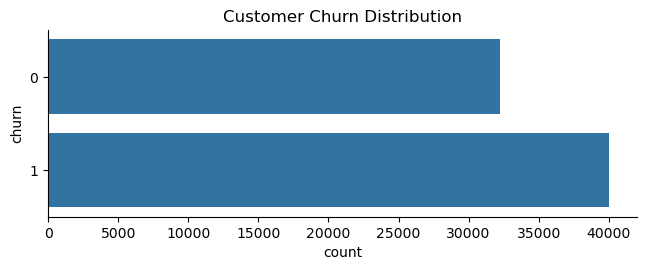

In [9]:
# Churn distribution visualization
sns.catplot(y="churn", kind="count", data=data, 
           height=2.6, aspect=2.5, orient='h')
plt.title("Customer Churn Distribution")
plt.show()

初步探索部分数字特征:
- subscription_age
- bill_avg
- reamining_contract
- service_failure_count
- download_avg
- upload_avg
- download_over_limit

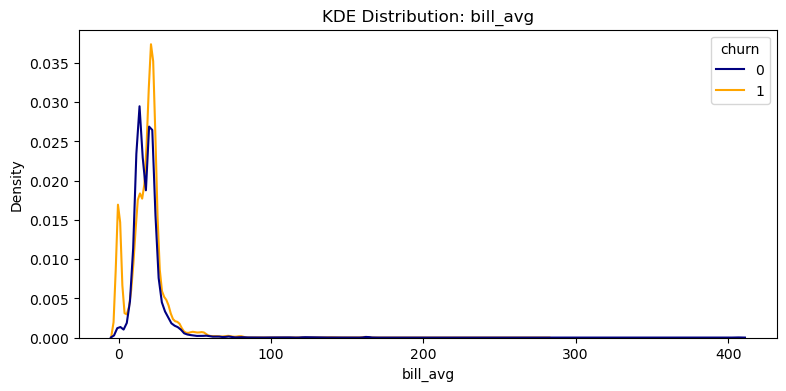

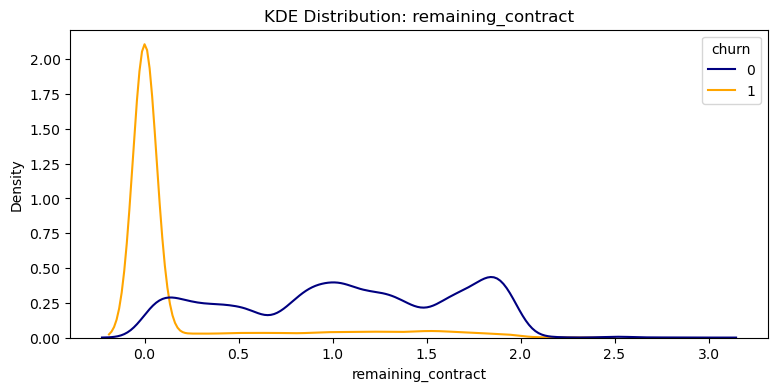

In [13]:
def kde_by_churn(feature):
    """Plot KDE comparison by churn status"""
    plt.figure(figsize=(9, 4))
    
    sns.kdeplot(data=data, x=feature, hue='churn', 
                palette=['navy', 'orange'])
    
    plt.title(f"KDE Distribution: {feature}")
    plt.show()

kde_by_churn('bill_avg')
kde_by_churn('remaining_contract')

1. bill_avg:
流失客户过去三个月账单平均值较高
2. remaining_contract:
流失客户明显没有合同

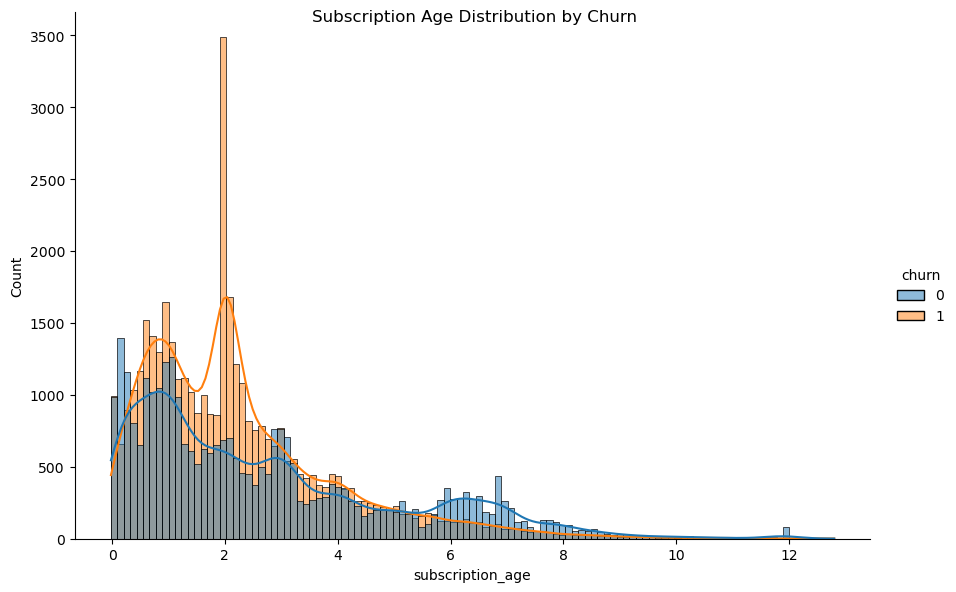

In [15]:
def histogram_churn_analysis(feature):
    """Analyze feature distribution across churn groups"""
    sns.displot(data=data, x=feature, hue='churn', kde=True, 
                height=6, aspect=1.5)
    plt.suptitle(f"{feature.replace('_', ' ').title()} Distribution by Churn")
    plt.show()

histogram_churn_analysis('subscription_age')

3. subscription_age
客户订阅年限大多集中在1-4年
流失的客户总体订阅年限比未流失客户较高

它的价值在10到40美元之间，但是也有例外，较高的平均账单客户也有非流失者；也有流失者。

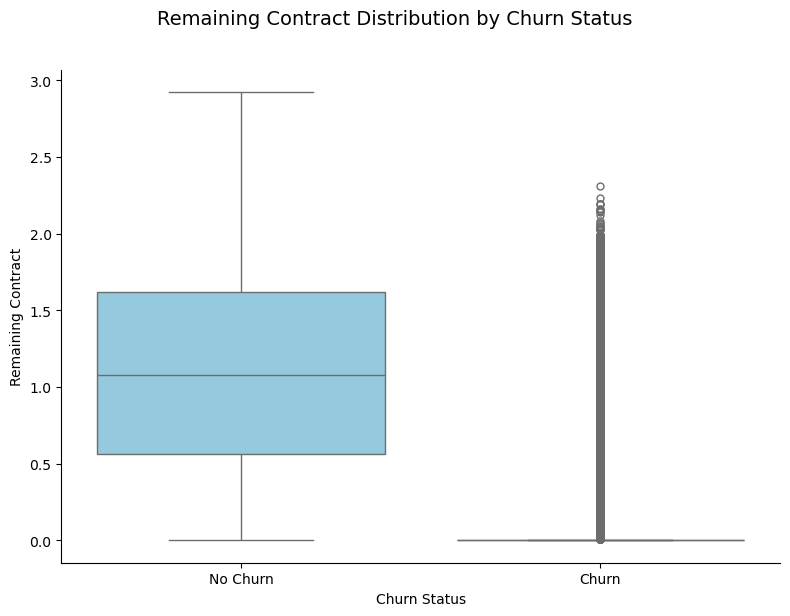

In [ ]:
def analyze_churn_by_feature(data, feature, plot_type="box", figsize=(8, 6)):
    """
    Analyze feature distribution across churn categories using various plot types
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Dataset containing the features
    feature : str
        Feature column name to analyze
    plot_type : str, optional
        Type of plot ('box', 'violin', 'strip', 'swarm')
    figsize : tuple, optional
        Figure size (width, height)
    """
    # Input validation
    if feature not in data.columns:
        similar_cols = [col for col in data.columns if any(word in col.lower() 
                       for word in feature.lower().split('_'))]
        raise ValueError(f"Column '{feature}' not found. Similar columns: {similar_cols}")
    
    # Create plot using catplot with explicit hue
    g = sns.catplot(
        x="churn", y=feature, 
        hue="churn",  
        kind=plot_type, 
        data=data,
        height=figsize[1], 
        aspect=figsize[0]/figsize[1],
        palette=['skyblue', 'salmon'],
        legend=False  
    )
    
    # Customize the plot
    g.set_axis_labels("Churn Status", feature.replace('_', ' ').title())
    g.set_xticklabels(["No Churn", "Churn"])
    g.fig.suptitle(f"{feature.replace('_', ' ').title()} Distribution by Churn Status", 
                   fontsize=14, y=1.02)
    
    plt.tight_layout()
    plt.show()
    
    return g

# Usage
analyze_churn_by_feature(data, "remaining_contract", plot_type="box")

那些没有签订合同的客户往往会流失，因为如果他们在签订合同时取消合同，就必须支付违约金。但也有例外，那些签了合同但仍在流失的客户。

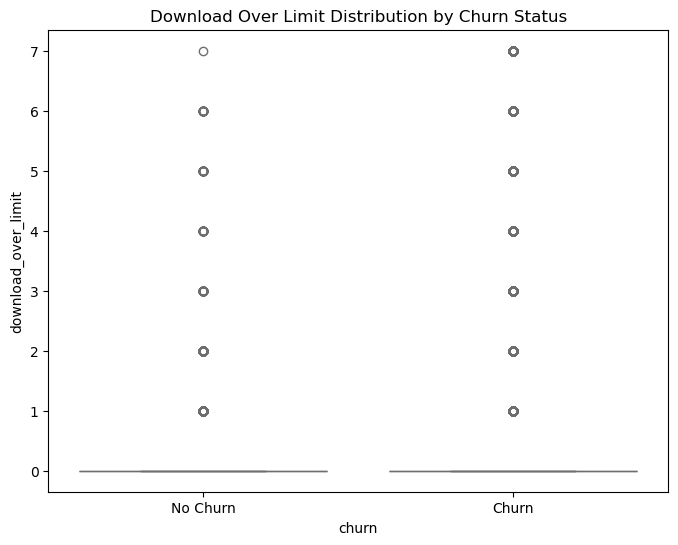

In [18]:
# Fixed version - add hue parameter as suggested
plt.figure(figsize=(8, 6))
sns.boxplot(x="churn", y="download_over_limit", data=data, 
            hue="churn",  # 添加 hue 参数
            palette=['lightblue', 'lightcoral'],
            legend=False)  # 避免重复图例
plt.title("Download Over Limit Distribution by Churn Status")
plt.xticks([0, 1], ["No Churn", "Churn"])
plt.show()

客户对下载超额比较谨慎，但和churn没有太大关系

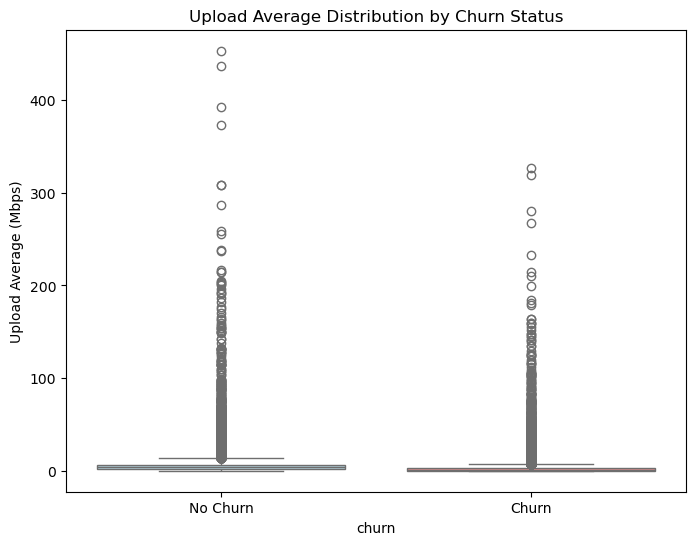

In [19]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="churn", y="upload_avg", data=data, 
            hue="churn",          
            palette=['lightblue', 'lightcoral'],
            legend=False)         
plt.title("Upload Average Distribution by Churn Status")
plt.ylabel("Upload Average (Mbps)")
plt.xticks([0, 1], ["No Churn", "Churn"])
plt.show()

看出此特征重要性比较低

离散特征：
- is_tv_subscriber
- is_movie_package_subscriber

In [20]:
# Analyze subscription types impact on churn and network usage
subscription_analysis = data.groupby(['is_tv_subscriber', 'is_movie_package_subscriber']).agg({
    'download_avg': 'mean',      # Average download speed
    'upload_avg': 'mean',        # Average upload speed
    'churn': ['sum', 'count']    # Churn count and total count
}).round(2)

# Flatten column names and reset index
subscription_analysis.columns = ['avg_download', 'avg_upload', 'churn_count', 'total_customers']
subscription_analysis['churn_rate'] = (
    subscription_analysis['churn_count'] / subscription_analysis['total_customers'] * 100
).round(2)

result = subscription_analysis.reset_index()
print("Subscription Analysis Results:")
print(result)

Subscription Analysis Results:
   is_tv_subscriber  is_movie_package_subscriber  avg_download  avg_upload  \
0                 0                            0         26.15        2.84   
1                 0                            1         41.60        2.85   
2                 1                            0         40.44        3.82   
3                 1                            1         58.07        5.49   

   churn_count  total_customers  churn_rate  
0        11964            13350       89.62  
1            2                2      100.00  
2        19891            34739       57.26  
3         8193            24183       33.88  


只订阅电视不订阅电影的客户流失比率最大
只订阅电影不订阅电视的客户上传下载量最少

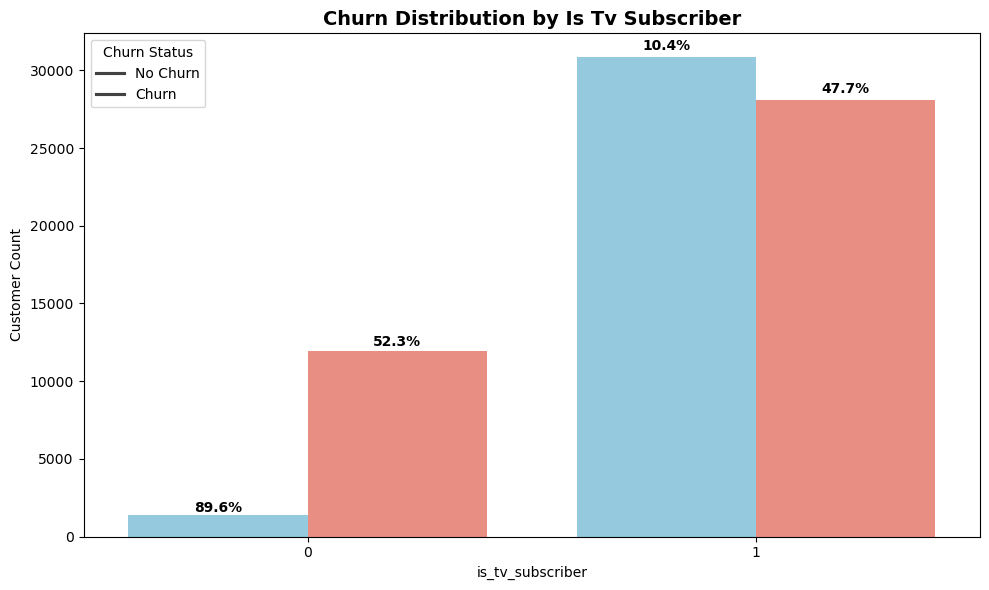


Churn Statistics for is_tv_subscriber:
                    count          percentage      
churn                   0        1          0     1
is_tv_subscriber                                   
0                  1386.0  11966.0       10.4  89.6
1                 30838.0  28084.0       52.3  47.7


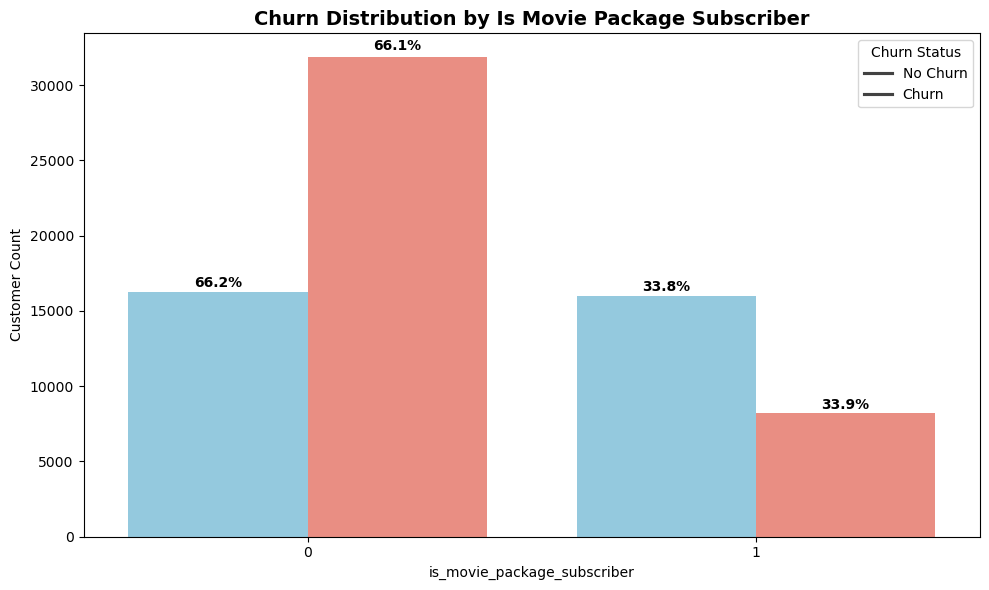


Churn Statistics for is_movie_package_subscriber:
                               count          percentage      
churn                              0        1          0     1
is_movie_package_subscriber                                   
0                            16234.0  31855.0       33.8  66.2
1                            15990.0   8195.0       66.1  33.9


In [21]:
def plot_churn_with_percentages(data, feature, orientation='v', figsize=(10, 6)):
    """
    Plot churn distribution with percentages for a categorical feature
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Dataset containing the features
    feature : str
        Categorical feature to analyze
    orientation : str, optional
        Plot orientation ('v' for vertical, 'h' for horizontal)
    figsize : tuple, optional
        Figure size (width, height)
    """
    # Calculate counts and percentages
    churn_counts = data.groupby(feature)["churn"].value_counts().reset_index()
    total_counts = data.groupby(feature).size().reset_index(name='total')
    
    # Merge to calculate percentages
    churn_stats = churn_counts.merge(total_counts, on=feature)
    churn_stats['percentage'] = (churn_stats['count'] / churn_stats['total'] * 100).round(1)
    
    # Create the plot
    plt.figure(figsize=figsize)
    
    if orientation == 'v':
        ax = sns.barplot(x=feature, y="count", hue='churn', data=churn_stats,
                        palette=['skyblue', 'salmon'])
        
        # Add percentage labels on bars
        for i, bar in enumerate(ax.patches):
            height = bar.get_height()
            if height > 0:  # Only label non-zero bars
                idx = i // len(churn_stats[feature].unique())
                pct = churn_stats.iloc[i]['percentage']
                ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                       f'{pct}%', ha='center', va='bottom', fontweight='bold')
        
        plt.ylabel("Customer Count")
    else:
        ax = sns.barplot(x="count", y=feature, hue='churn', data=churn_stats,
                        palette=['skyblue', 'salmon'])
        plt.xlabel("Customer Count")
    
    plt.title(f"Churn Distribution by {feature.replace('_', ' ').title()}", 
              fontsize=14, fontweight='bold')
    plt.legend(title="Churn Status", labels=["No Churn", "Churn"])
    plt.tight_layout()
    plt.show()
    
    # Display summary statistics
    print(f"\nChurn Statistics for {feature}:")
    print("=" * 50)
    summary = churn_stats.pivot(index=feature, columns='churn', values=['count', 'percentage'])
    print(summary)
    
    return churn_stats

# Usage
tv_stats = plot_churn_with_percentages(data, "is_tv_subscriber")
movie_stats = plot_churn_with_percentages(data, "is_movie_package_subscriber")

可以看出：订阅者客户更不倾向于流失
没有订阅电视的客户更容易流失

#### 订阅者和账单有无相关关系

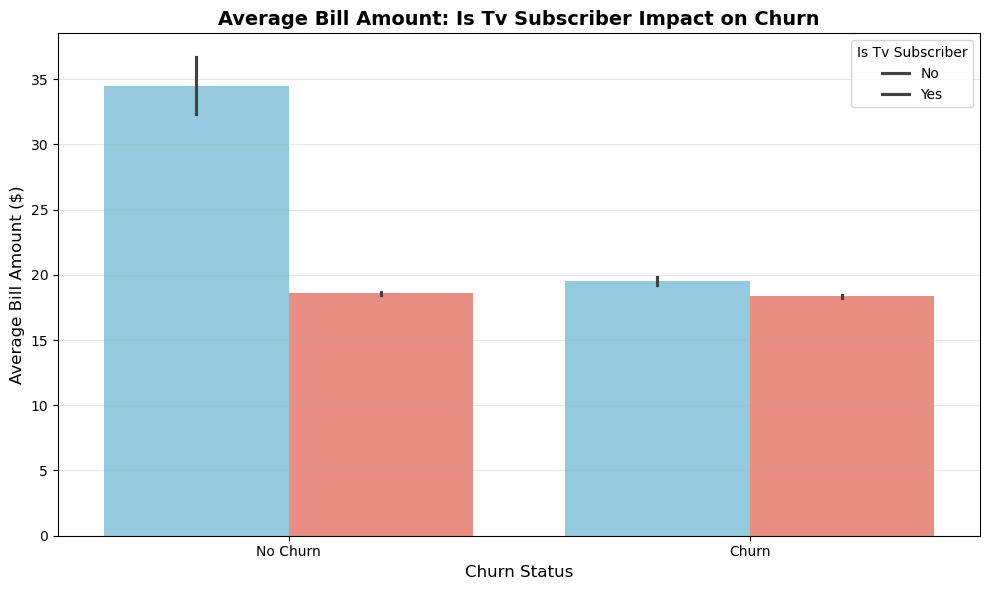


Bill Statistics for Is Tv Subscriber:
                         mean  median    std
is_tv_subscriber churn                      
0                0      34.49    25.0  41.27
                 1      19.50    20.0  16.76
1                0      18.57    18.0   9.99
                 1      18.35    20.0  11.12


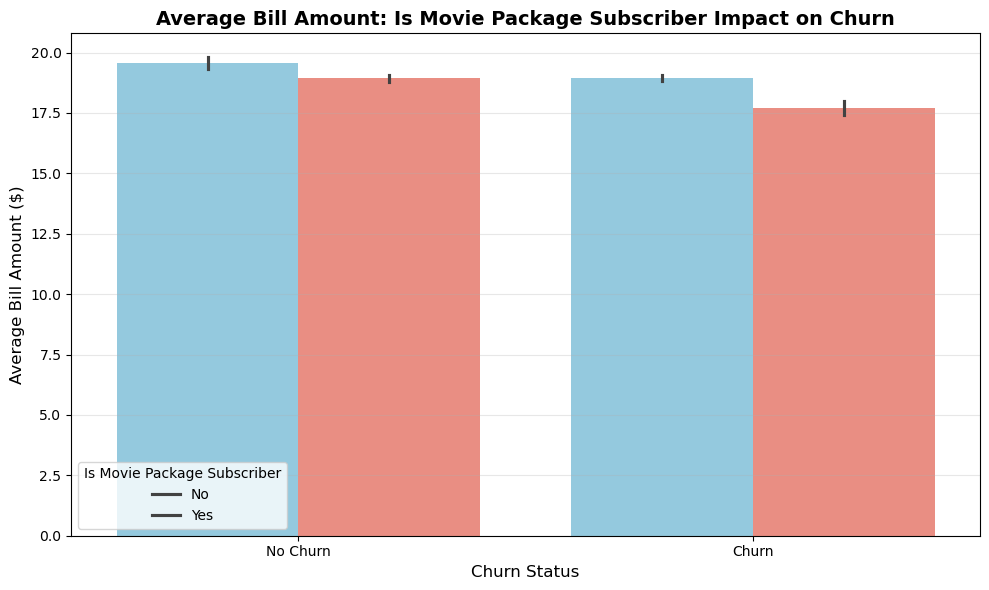


Bill Statistics for Is Movie Package Subscriber:
                                    mean  median    std
is_movie_package_subscriber churn                      
0                           0      19.56    19.0  15.87
                            1      18.95    20.0  13.22
1                           0      18.94    17.0  10.25
                            1      17.71    19.0  12.45


In [22]:
def analyze_bill_by_subscription_type(data, subscription_feature, figsize=(10, 6)):
    """
    Analyze average bill amount by subscription type and churn status
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Dataset containing the features
    subscription_feature : str
        Subscription feature to analyze
    figsize : tuple, optional
        Figure size (width, height)
    """
    plt.figure(figsize=figsize)
    
    sns.barplot(x="churn", y="bill_avg", hue=subscription_feature, data=data,
               palette=['skyblue', 'salmon'])
    
    # Format the plot
    feature_name = subscription_feature.replace('_', ' ').title()
    plt.title(f"Average Bill Amount: {feature_name} Impact on Churn", 
              fontsize=14, fontweight='bold')
    plt.xlabel("Churn Status", fontsize=12)
    plt.ylabel("Average Bill Amount ($)", fontsize=12)
    plt.xticks([0, 1], ["No Churn", "Churn"])
    
    # Improve legend
    plt.legend(title=feature_name, labels=["No", "Yes"])
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Display summary statistics
    print(f"\nBill Statistics for {feature_name}:")
    print("=" * 50)
    summary = data.groupby([subscription_feature, 'churn'])['bill_avg'].agg(['mean', 'median', 'std']).round(2)
    print(summary)

# Usage
for subscription in ["is_tv_subscriber", "is_movie_package_subscriber"]:
    analyze_bill_by_subscription_type(data, subscription)

没有订阅电视or电影套餐的客户账单平均较低

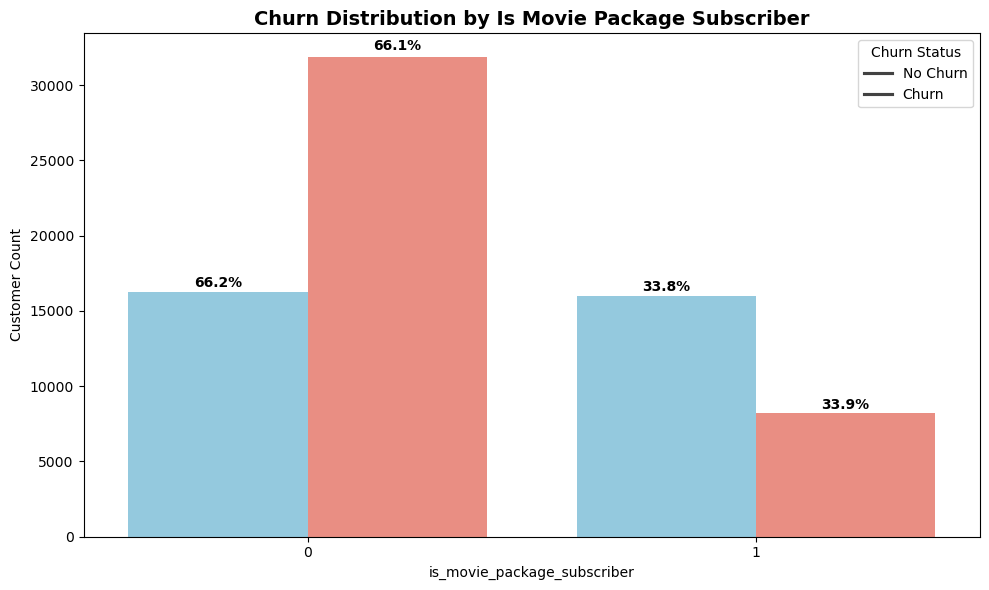


Churn Statistics for is_movie_package_subscriber:
                               count          percentage      
churn                              0        1          0     1
is_movie_package_subscriber                                   
0                            16234.0  31855.0       33.8  66.2
1                            15990.0   8195.0       66.1  33.9


,is_movie_package_subscriber,churn,count,total,percentage
0,0,1,31855,48089,66.2
1,0,0,16234,48089,33.8
2,1,0,15990,24185,66.1
3,1,1,8195,24185,33.9


In [23]:
# Direct call using the optimized functions
plot_churn_with_percentages(data, "is_movie_package_subscriber")

In [24]:
def explore_data_distribution(data, columns_to_check=['churn', 'is_tv_subscriber', 'is_movie_package_subscriber']):
    """
    Explore data distribution for specified columns
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Dataset to explore
    columns_to_check : list
        List of column names to examine
    """
    print("Data Distribution Analysis:")
    print("=" * 50)
    
    for col in columns_to_check:
        if col not in data.columns:
            print(f"Warning: Column '{col}' not found in dataset")
            continue
            
        print(f"\n{col.replace('_', ' ').title()}:")
        print("-" * 30)
        
        # Show first 10 values
        print("First 10 values:")
        print(data[col].head(10).tolist())
        
        # Show unique values
        unique_vals = data[col].unique()
        print(f"Unique values: {unique_vals}")
        
        # Show value counts
        print("Value distribution:")
        print(data[col].value_counts().sort_index())

# Usage
explore_data_distribution(data)

Data Distribution Analysis:

Churn:
------------------------------
First 10 values:
[0, 1, 1, 1, 1, 0, 1, 1, 1, 1]
Unique values: [0 1]
Value distribution:
churn
0    32224
1    40050
Name: count, dtype: int64

Is Tv Subscriber:
------------------------------
First 10 values:
[1, 0, 1, 0, 0, 1, 0, 0, 0, 0]
Unique values: [1 0]
Value distribution:
is_tv_subscriber
0    13352
1    58922
Name: count, dtype: int64

Is Movie Package Subscriber:
------------------------------
First 10 values:
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
Unique values: [0 1]
Value distribution:
is_movie_package_subscriber
0    48089
1    24185
Name: count, dtype: int64


明显看出：订阅了电影套餐的客户更不容易流失，和订阅电视的客户相似

data['churn_rate'] = data['churn']
g = sns.FacetGrid(data, col="is_movie_package_subscriber", height=4, aspect=.9)
ax = g.map(sns.barplot, "is_tv_subscriber", "churn_rate", palette = "Blues_d", order= ['0', '1'])


基于单变量的churn_count分析
两离散变量相关性较大

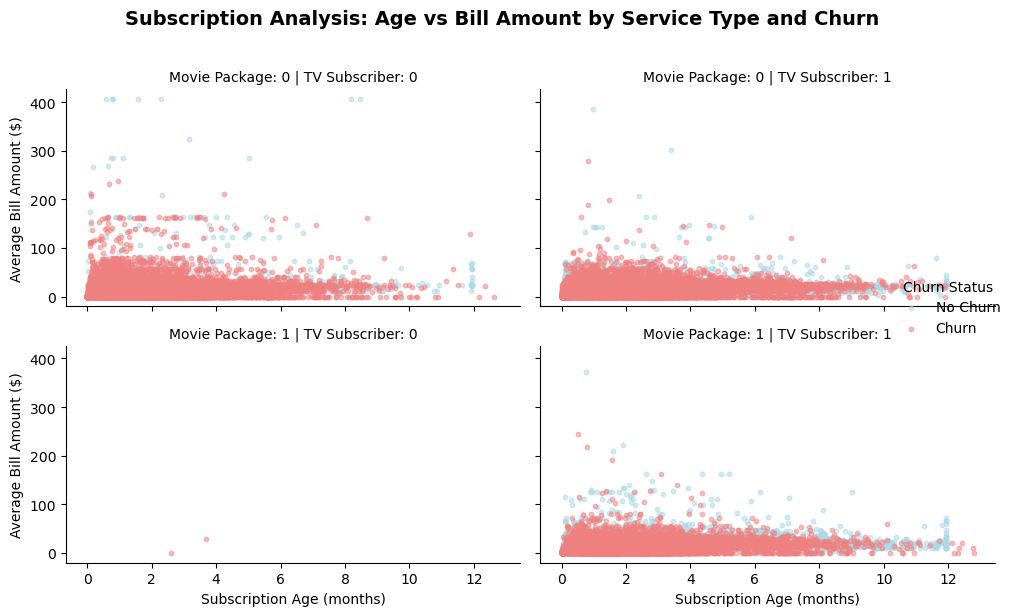

In [ ]:
def plot_subscription_facet_analysis(data, figsize_multiplier=3, alpha=0.5, point_size=10):
    """
    Create faceted scatter plot analysis of subscription age vs bill amount
    across different subscription types and churn status
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Dataset containing subscription and billing data
    figsize_multiplier : int, optional
        Height multiplier for each subplot
    alpha : float, optional
        Transparency of scatter points
    point_size : int, optional
        Size of scatter points
    """
    # Validate required columns
    required_cols = ['is_movie_package_subscriber', 'is_tv_subscriber', 'churn', 
                     'subscription_age', 'bill_avg']
    missing_cols = [col for col in required_cols if col not in data.columns]
    
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Create the facet grid
    g = sns.FacetGrid(data, 
                      row='is_movie_package_subscriber', 
                      col='is_tv_subscriber', 
                      hue='churn',
                      aspect=1.5, 
                      height=figsize_multiplier,
                      palette=['lightblue', 'lightcoral'])
    
    # Map scatter plot to each facet
    g.map(plt.scatter, "subscription_age", "bill_avg", 
          alpha=alpha, s=point_size)
    
    # Customize the plot
    g.set_axis_labels("Subscription Age (months)", "Average Bill Amount ($)")
    g.set_titles(col_template="TV Subscriber: {col_name}", 
                 row_template="Movie Package: {row_name}")
    
    # Add overall title
    g.fig.suptitle("Subscription Analysis: Age vs Bill Amount by Service Type and Churn", 
                   fontsize=14, fontweight='bold', y=1.02)
    
    # Add legend with custom labels
    g.add_legend(title="Churn Status", labels=["No Churn", "Churn"])
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    return g

subscription_grid = plot_subscription_facet_analysis(data)

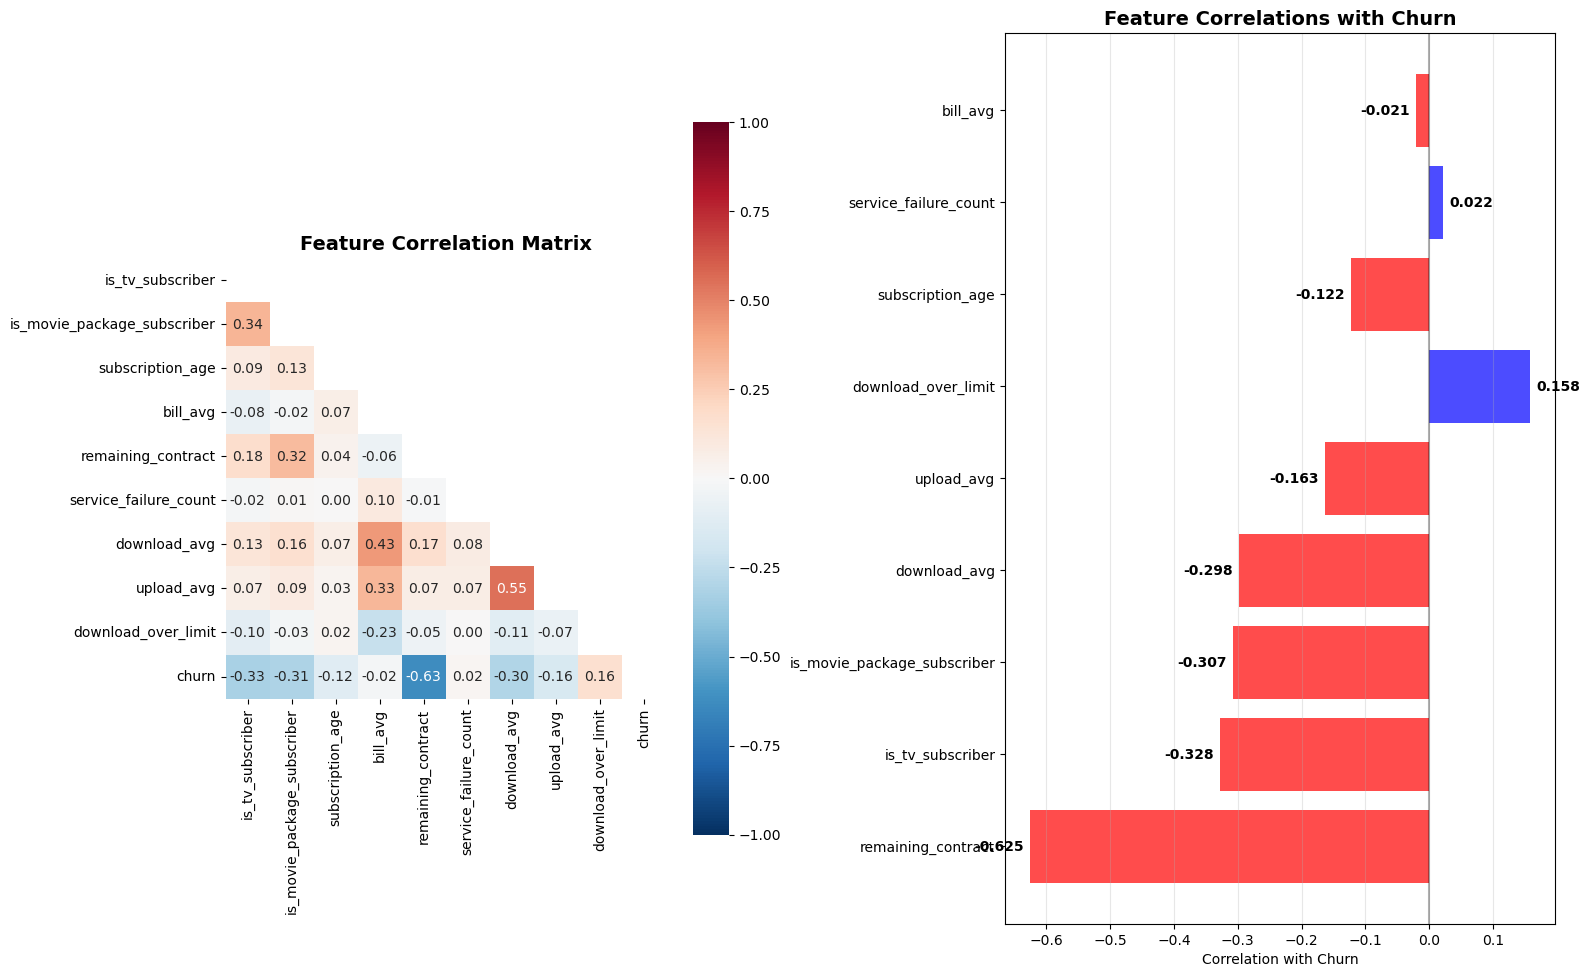


Top correlations with churn:
remaining_contract: -0.625
is_tv_subscriber: -0.328
is_movie_package_subscriber: -0.307
download_avg: -0.298
upload_avg: -0.163


In [26]:
def advanced_correlation_analysis(data, target_column='churn', figsize=(16, 10)):
    """
    Advanced correlation analysis with target variable focus
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Dataset containing features
    target_column : str, optional
        Target variable to highlight
    figsize : tuple, optional
        Figure size (width, height)
    """
    # Select numeric columns
    numeric_data = data.select_dtypes(include=[np.number])
    
    if numeric_data.empty:
        print("No numeric columns found for correlation analysis")
        return None
    
    # Calculate correlation matrix
    correlation = numeric_data.corr()
    
    # Create subplot layout
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Plot 1: Full correlation matrix
    mask = np.triu(np.ones_like(correlation, dtype=bool))
    sns.heatmap(correlation, 
                mask=mask,
                vmin=-1, vmax=1, 
                annot=True, 
                fmt='.2f',
                cmap='RdBu_r',
                center=0,
                square=True,
                ax=axes[0],
                cbar_kws={"shrink": 0.8})
    
    axes[0].set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('')
    axes[0].set_ylabel('')
    
    # Plot 2: Target variable correlations
    if target_column in correlation.columns:
        target_corr = correlation[target_column].drop(target_column).sort_values(key=abs, ascending=False)
        
        colors = ['red' if x < 0 else 'blue' for x in target_corr.values]
        bars = axes[1].barh(range(len(target_corr)), target_corr.values, color=colors, alpha=0.7)
        
        axes[1].set_yticks(range(len(target_corr)))
        axes[1].set_yticklabels(target_corr.index)
        axes[1].set_xlabel('Correlation with ' + target_column.replace('_', ' ').title())
        axes[1].set_title(f'Feature Correlations with {target_column.title()}', 
                         fontsize=14, fontweight='bold')
        axes[1].axvline(x=0, color='black', linestyle='-', alpha=0.3)
        axes[1].grid(axis='x', alpha=0.3)
        
        # Add value labels on bars
        for i, (bar, value) in enumerate(zip(bars, target_corr.values)):
            axes[1].text(value + 0.01 if value >= 0 else value - 0.01, 
                        bar.get_y() + bar.get_height()/2, 
                        f'{value:.3f}', 
                        ha='left' if value >= 0 else 'right', 
                        va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print top correlations with target
    if target_column in correlation.columns:
        print(f"\nTop correlations with {target_column}:")
        print("=" * 40)
        target_corr_sorted = correlation[target_column].drop(target_column).sort_values(key=abs, ascending=False)
        for feature, corr_val in target_corr_sorted.head(5).items():
            print(f"{feature}: {corr_val:.3f}")
    
    return correlation

correlation_analysis = advanced_correlation_analysis(data, target_column='churn')

In [32]:
def preprocess_churn_data(data, target_column='churn', test_size=0.2, random_state=42):
    """
    Comprehensive data preprocessing for churn prediction model
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Raw dataset containing features and target
    target_column : str, optional
        Name of the target variable column
    test_size : float, optional
        Proportion of data for testing
    random_state : int, optional
        Random state for reproducibility
        
    Returns:
    --------
    X_train, X_test, y_train, y_test : arrays
        Preprocessed training and testing sets
    """
    print("Data Preprocessing Steps:")
    print("=" * 40)
    
    # Create a copy to avoid modifying original data
    processed_data = data.copy()
    
    # 1. Handle missing values
    print(f"Original shape: {processed_data.shape}")
    
    # Check for missing values
    missing_info = processed_data.isnull().sum()
    if missing_info.sum() > 0:
        print(f"Missing values found:\n{missing_info[missing_info > 0]}")
        
        # Drop rows with missing values
        processed_data.dropna(axis=0, inplace=True)
        print(f"After dropping rows with NaN: {processed_data.shape}")
        
        # Drop columns with remaining missing values
        processed_data.dropna(axis=1, inplace=True)
        print(f"After dropping columns with NaN: {processed_data.shape}")
    else:
        print("No missing values found")
    
    # 2. Fix subscription age (convert to absolute values)
    if 'subscription_age' in processed_data.columns:
        negative_count = (processed_data['subscription_age'] < 0).sum()
        if negative_count > 0:
            print(f"Converting {negative_count} negative subscription_age values to positive")
            processed_data['subscription_age'] = processed_data['subscription_age'].abs()
    
    # 3. Remove unnecessary columns (if they exist)
    columns_to_drop = ['churn_rate']  # Add other columns as needed
    existing_drops = [col for col in columns_to_drop if col in processed_data.columns]
    if existing_drops:
        processed_data.drop(existing_drops, axis=1, inplace=True)
        print(f"Dropped columns: {existing_drops}")
    
    # 4. Separate features and target
    if target_column not in processed_data.columns:
        raise ValueError(f"Target column '{target_column}' not found in dataset")
    
    # target is the last column, features are all others
    X = processed_data.drop(target_column, axis=1)
    y = processed_data[target_column]
    
    print(f"Final dataset shape - Features: {X.shape}, Target: {y.shape}")
    print(f"Target distribution:\n{y.value_counts()}")
    
    return X, y

X, y = preprocess_churn_data(data)

# Display results
print("\nFeature Matrix (X):")
print(f"Shape: {X.shape}")
print(f"Columns: {list(X.columns)}")
print("\nFirst few rows:")
print(X.head())

print(f"\nTarget Variable (y):")
print(f"Shape: {y.shape}")
print(f"Distribution: {y.value_counts().to_dict()}")

Data Preprocessing Steps:
Original shape: (50375, 10)
No missing values found
Final dataset shape - Features: (50375, 9), Target: (50375,)
Target distribution:
churn
0    30044
1    20331
Name: count, dtype: int64

Feature Matrix (X):
Shape: (50375, 9)
Columns: ['is_tv_subscriber', 'is_movie_package_subscriber', 'subscription_age', 'bill_avg', 'remaining_contract', 'service_failure_count', 'download_avg', 'upload_avg', 'download_over_limit']

First few rows:
    is_tv_subscriber  is_movie_package_subscriber  subscription_age  bill_avg  \
0                  1                            0             11.95        25   
2                  1                            0              8.91        16   
5                  1                            1             11.94        32   
6                  0                            0              8.96        18   
10                 1                            1              8.44        17   

    remaining_contract  service_failure_count  dow

#### 利用信息增益进行特征选择

Feature Importance Rankings:
                       Feature  Importance
0           remaining_contract      0.4366
1                 download_avg      0.1220
2                   upload_avg      0.1168
3             subscription_age      0.0666
4                     bill_avg      0.0572
5             is_tv_subscriber      0.0506
6  is_movie_package_subscriber      0.0443
7          download_over_limit      0.0080
8        service_failure_count      0.0000


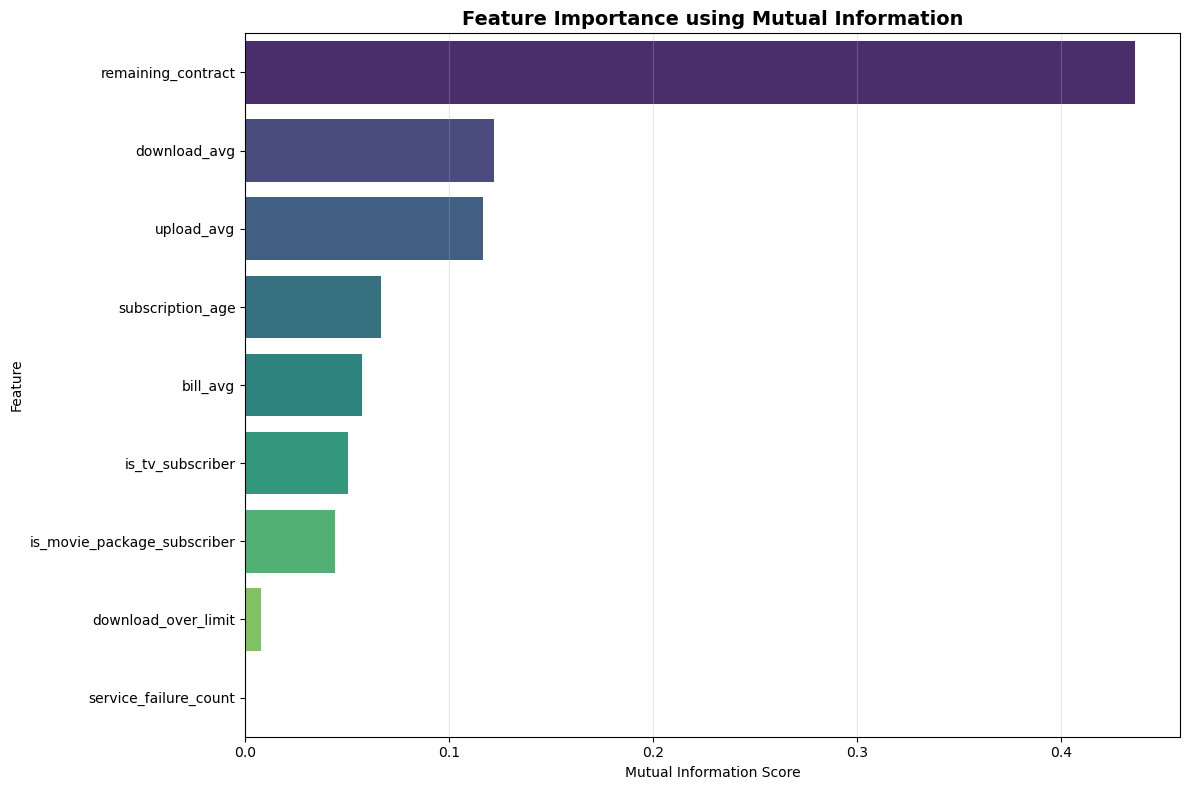


Summary Statistics:
Total features analyzed: 9
Mean importance: 0.1002
Most important feature: remaining_contract (0.4366)


In [34]:
# Enhanced feature importance analysis using mutual information
from sklearn.feature_selection import mutual_info_classif

# Calculate mutual information scores
mi_scores = mutual_info_classif(X, y, random_state=42)

# Create feature importance DataFrame (simplified approach)
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': mi_scores
}).sort_values('Importance', ascending=False).reset_index(drop=True)

# Display results
print("Feature Importance Rankings:")
print("=" * 40)
print(feature_importance_df.round(4))

# Add visualization
plt.figure(figsize=(12, 8))
top_15 = feature_importance_df.head(15)

sns.barplot(x='Importance', y='Feature', data=top_15, 
           palette='viridis', hue='Feature', legend=False)
plt.title('Feature Importance using Mutual Information', fontsize=14, fontweight='bold')
plt.xlabel('Mutual Information Score')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nSummary Statistics:")
print(f"Total features analyzed: {len(feature_importance_df)}")
print(f"Mean importance: {mi_scores.mean():.4f}")
print(f"Most important feature: {feature_importance_df.iloc[0]['Feature']} ({feature_importance_df.iloc[0]['Importance']:.4f})")

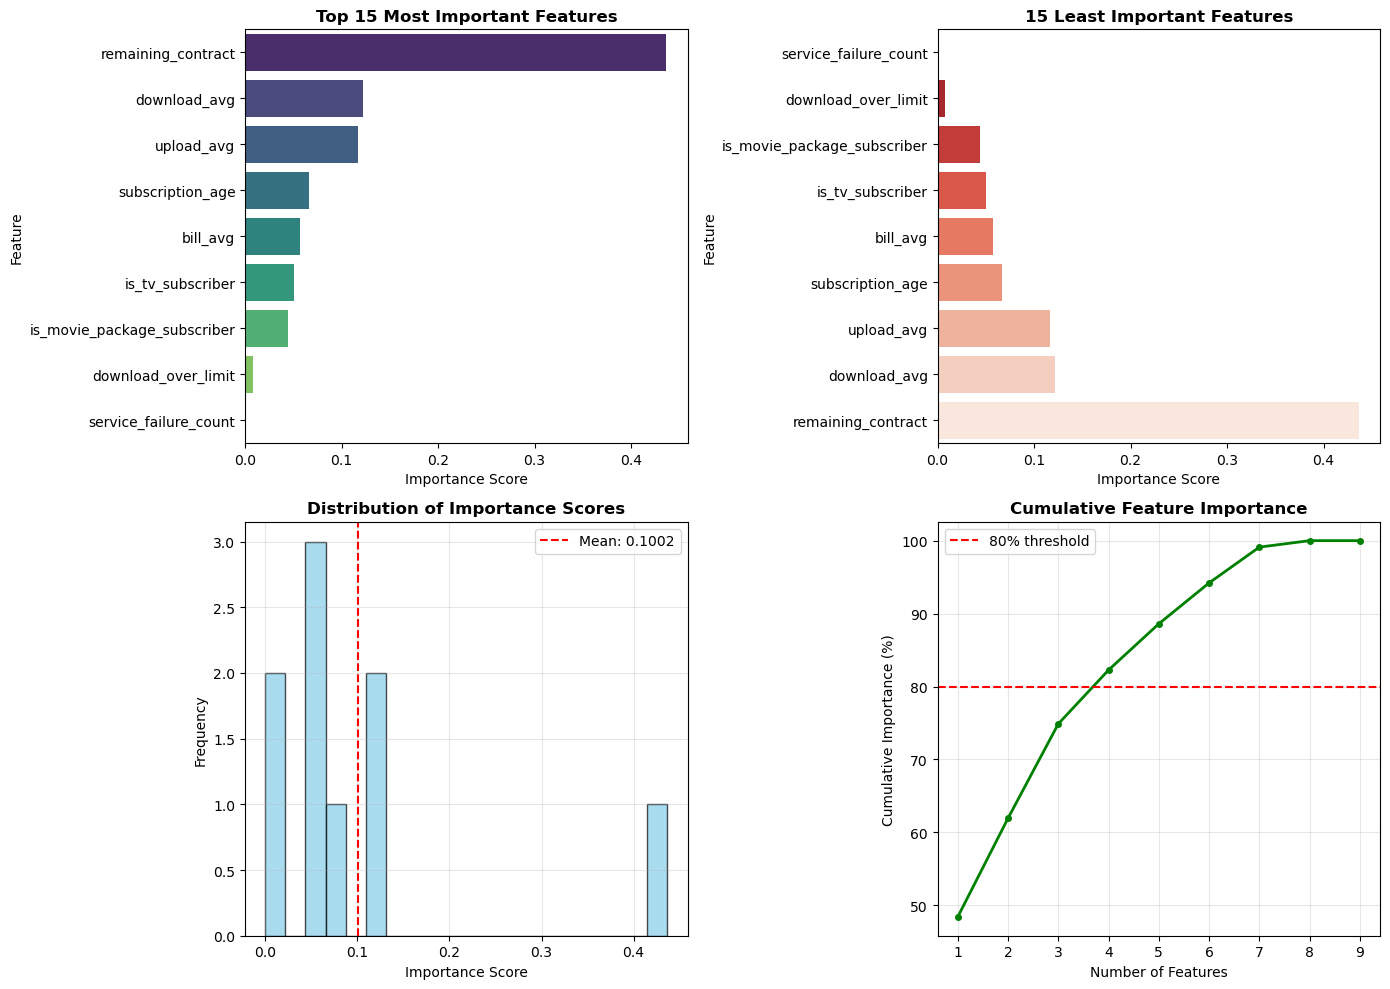

In [40]:
def advanced_feature_importance_plot(importance_df, figsize=(14, 10), palette='viridis'):
    """
    Create advanced feature importance visualization with multiple views - Fixed Version
    """
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # Sort data for different views
    sorted_asc = importance_df.sort_values('Importance', ascending=True)
    sorted_desc = importance_df.sort_values('Importance', ascending=False)
    
    # Plot 1: Top 15 features (descending) - FIXED
    top_15 = sorted_desc.head(15)
    sns.barplot(x='Importance', y='Feature', data=top_15, 
                hue='Feature',        
                palette=palette, 
                ax=axes[0,0],
                legend=False)         
    axes[0,0].set_title('Top 15 Most Important Features', fontweight='bold')
    axes[0,0].set_xlabel('Importance Score')
    
    # Plot 2: Bottom 15 features (ascending) - FIXED
    bottom_15 = sorted_asc.head(15)
    sns.barplot(x='Importance', y='Feature', data=bottom_15,
                hue='Feature',        
                palette='Reds_r', 
                ax=axes[0,1],
                legend=False)         
    axes[0,1].set_title('15 Least Important Features', fontweight='bold')
    axes[0,1].set_xlabel('Importance Score')
    
    # Plot 3: Distribution of importance scores (no change needed)
    axes[1,0].hist(importance_df['Importance'], bins=20, color='skyblue', 
                   alpha=0.7, edgecolor='black')
    axes[1,0].axvline(importance_df['Importance'].mean(), color='red', 
                      linestyle='--', label=f"Mean: {importance_df['Importance'].mean():.4f}")
    axes[1,0].set_title('Distribution of Importance Scores', fontweight='bold')
    axes[1,0].set_xlabel('Importance Score')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].legend()
    axes[1,0].grid(alpha=0.3)
    
    # Plot 4: Cumulative importance (no change needed)
    cumulative = sorted_desc['Importance'].cumsum() / sorted_desc['Importance'].sum() * 100
    axes[1,1].plot(range(1, len(cumulative) + 1), cumulative, 
                   marker='o', linewidth=2, markersize=4, color='green')
    axes[1,1].axhline(80, color='red', linestyle='--', label='80% threshold')
    axes[1,1].set_title('Cumulative Feature Importance', fontweight='bold')
    axes[1,1].set_xlabel('Number of Features')
    axes[1,1].set_ylabel('Cumulative Importance (%)')
    axes[1,1].legend()
    axes[1,1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

advanced_feature_importance_plot(feature_importance_df)

如图可见：相关性最高的五个特征分别是“remaining_contract”，“download_avg”，“upload_avg”，“bill_avg”和“is_tv_sunscripter”

In [41]:
# Select important features for modeling
features = ["subscription_age", "bill_avg", "remaining_contract", 
           "download_avg", "upload_avg"]

# Create feature dataset
data2 = data[features + ['churn']].copy()
X2 = data2[features]  # Feature matrix
y2 = data2['churn']   # Target variable

print(f"Feature dataset shape: {data2.shape}")
y2 = data2['churn']

Feature dataset shape: (50375, 6)


#### 模型训练

In [42]:
# Split data (70% train, 30% test) with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X2, y2, test_size=0.3, random_state=42, stratify=y2
)

print(f"Split complete: Train {len(X_train)} | Test {len(X_test)}")

Split complete: Train 35262 | Test 15113


In [57]:
def apply_smote_with_validation(X_train, y_train, random_state=42):
    """
    Apply SMOTE with missing value handling
    
    Parameters:
    -----------
    X_train : pandas.DataFrame
        Training feature matrix
    y_train : pandas.Series
        Training target variable
    random_state : int, optional
        Random state for reproducibility
        
    Returns:
    --------
    X_resampled : array-like
        Oversampled feature matrix
    y_resampled : array-like
        Oversampled target variable
    """
    # Check for missing values
    missing_info = X_train.isnull().sum()
    total_missing = missing_info.sum()
    
    if total_missing > 0:
        print(f"⚠️  Found {total_missing} missing values:")
        print(missing_info[missing_info > 0])
        
        # Remove rows with missing values
        mask = ~X_train.isnull().any(axis=1)
        X_train_clean = X_train[mask]
        y_train_clean = y_train[mask]
        
        print(f"Removed {len(X_train) - len(X_train_clean)} rows with missing values")
        print(f"Dataset size: {len(X_train)} → {len(X_train_clean)}")
    else:
        X_train_clean = X_train
        y_train_clean = y_train
        print("No missing values found")
    
    # Apply SMOTE
    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X_train_clean, y_train_clean)
    
    print(f"SMOTE applied: {len(X_train_clean)} → {len(X_resampled)} samples")
    
    return X_resampled, y_resampled

# Apply SMOTE with missing value handling
X_resampled, y_resampled = apply_smote_with_validation(X_train, y_train)

No missing values found
SMOTE applied: 35262 → 42062 samples


In [58]:
def show_classification_metrics(cm, class_names=['No Churn', 'Churn']):
    """
    Display key classification metrics from confusion matrix
    
    Parameters:
    -----------
    cm : array-like
        2x2 confusion matrix
    class_names : list, optional
        Names for the classes
    """
    # Extract values
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate metrics
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    # Display results
    print("Classification Performance:")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall:    {recall:.3f}")
    print(f"  F1-Score:  {f1:.3f}")
    print(f"  Accuracy:  {accuracy:.3f}")
    
    return {'precision': precision, 'recall': recall, 'f1': f1, 'accuracy': accuracy}

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix_seaborn(cm, classes, title='Confusion Matrix', 
                                 figsize=(8, 6), normalize=False):
    """
    Plot confusion matrix using seaborn for better aesthetics
    
    Parameters:
    -----------
    cm : array-like
        Confusion matrix
    classes : list
        Class labels
    title : str, optional
        Plot title
    figsize : tuple, optional
        Figure size
    normalize : bool, optional
        Whether to normalize values
    """
    # Normalize if requested
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    
    # Create heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'label': 'Count'})
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

In [60]:
def train_optimal_decision_tree(X, y, cv_folds=5, random_state=42):
    """
    Train decision tree with hyperparameter optimization
    
    Parameters:
    -----------
    X, y : array-like
        Training features and target
    cv_folds : int, optional
        Cross-validation folds
    random_state : int, optional
        Random state for reproducibility
        
    Returns:
    --------
    best_model : DecisionTreeClassifier
        Optimized model
    """
    # Setup cross-validation
    cv = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    
    # Define model and parameters
    dt = DecisionTreeClassifier(random_state=random_state)
    params = {
        'max_depth': range(1, 21),
        'criterion': ['entropy', 'gini']
    }
    
    # Grid search
    grid_search = GridSearchCV(dt, params, cv=cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X, y)
    
    print(f"Best Score: {grid_search.best_score_:.3f}")
    print(f"Best Params: {grid_search.best_params_}")
    
    return grid_search.best_estimator_


Training Decision Tree Model...
Best Score: 0.932
Best Params: {'criterion': 'gini', 'max_depth': 11}

 Decision Tree Performance:
Classification Performance:
  Precision: 0.963
  Recall:    0.898
  F1-Score:  0.929
  Accuracy:  0.945


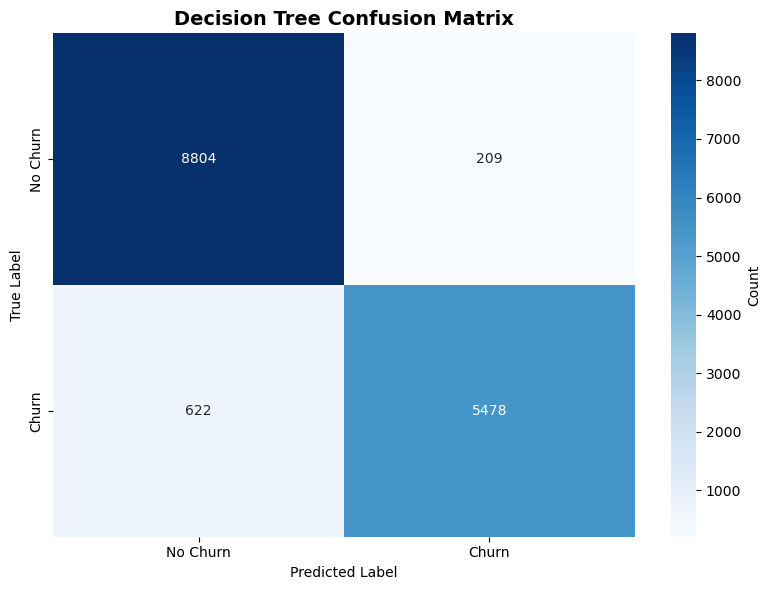

In [61]:
# Train Decision Tree with hyperparameter optimization
print("Training Decision Tree Model...")
dt_model = train_optimal_decision_tree(X_resampled, y_resampled)

# Make predictions on test set
y_pred_dt = dt_model.predict(X_test)

# Calculate confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)

# Display performance metrics
print("\n Decision Tree Performance:")
show_classification_metrics(cm_dt)

# Plot confusion matrix
class_names = ['No Churn', 'Churn']
plot_confusion_matrix_seaborn(cm_dt, classes=class_names, 
                     title='Decision Tree Confusion Matrix')

In [64]:
def clean_and_train_naive_bayes(X_train, y_train, X_test, y_test):
    """
    Clean data and train Naive Bayes classifiers
    
    Parameters:
    -----------
    X_train, y_train : array-like
        Training data (may contain NaN)
    X_test, y_test : array-like
        Test data
        
    Returns:
    --------
    results : dict
        Training results for each classifier
    """
    print(" Data Cleaning and Naive Bayes Training")
    print("=" * 50)
    
    # Check for missing values
    if isinstance(X_train, pd.DataFrame):
        missing_train = X_train.isnull().sum().sum()
        missing_test = X_test.isnull().sum().sum()
    else:
        missing_train = np.isnan(X_train).sum()
        missing_test = np.isnan(X_test).sum()
    
    print(f"Missing values - Train: {missing_train}, Test: {missing_test}")
    
    if missing_train > 0 or missing_test > 0:
        print("Cleaning missing values...")
        
        # For training data
        if isinstance(X_train, pd.DataFrame):
            # Remove rows with any missing values
            clean_mask = ~X_train.isnull().any(axis=1)
            X_train_clean = X_train[clean_mask]
            y_train_clean = y_train[clean_mask] if hasattr(y_train, 'iloc') else y_train[clean_mask]
        else:
            # For numpy arrays
            clean_mask = ~np.isnan(X_train).any(axis=1)
            X_train_clean = X_train[clean_mask]
            y_train_clean = y_train[clean_mask]
        
        # For test data
        if isinstance(X_test, pd.DataFrame):
            clean_mask_test = ~X_test.isnull().any(axis=1)
            X_test_clean = X_test[clean_mask_test]
            y_test_clean = y_test[clean_mask_test] if hasattr(y_test, 'iloc') else y_test[clean_mask_test]
        else:
            clean_mask_test = ~np.isnan(X_test).any(axis=1)
            X_test_clean = X_test[clean_mask_test]
            y_test_clean = y_test[clean_mask_test]
        
        print(f"Cleaned data - Train: {len(X_train_clean)}, Test: {len(X_test_clean)}")
    else:
        X_train_clean, y_train_clean = X_train, y_train
        X_test_clean, y_test_clean = X_test, y_test
        print("No missing values found")
    
    # Define classifiers
    nb_classifiers = {
        'Gaussian NB': GaussianNB(),
        'Bernoulli NB': BernoulliNB(),
        'Multinomial NB': MultinomialNB()
    }
    
    results = {}
    
    print(f"\n Training Naive Bayes Classifiers:")
    print("-" * 40)
    
    for name, clf in nb_classifiers.items():
        try:
            # Train and predict
            clf.fit(X_train_clean, y_train_clean)
            y_pred = clf.predict(X_test_clean)
            accuracy = accuracy_score(y_test_clean, y_pred)
            
            print(f"{name:15} Accuracy: {accuracy:.4f}")
            
            results[name] = {
                'model': clf,
                'predictions': y_pred,
                'accuracy': accuracy
            }
            
        except Exception as e:
            print(f"{name:15} Error: {str(e)[:50]}...")
            results[name] = None
    
    return results, X_train_clean, y_train_clean, X_test_clean, y_test_clean

# Clean data and train models
nb_results, X_train_clean, y_train_clean, X_test_clean, y_test_clean = clean_and_train_naive_bayes(
    X_resampled, y_resampled, X_test, y_test
)

 Data Cleaning and Naive Bayes Training
Missing values - Train: 0, Test: 0
No missing values found

 Training Naive Bayes Classifiers:
----------------------------------------
Gaussian NB     Accuracy: 0.7926
Bernoulli NB    Accuracy: 0.9418
Multinomial NB  Accuracy: 0.6574


In [68]:
def train_random_forest_with_grid_search(X, y, cv_folds=5, test_size=0.3):
    """
    Train Random Forest with Grid Search optimization
    
    Parameters:
    -----------
    X, y : array-like
        Training data
    cv_folds : int, optional
        Cross-validation folds
    test_size : float, optional
        Test set proportion
        
    Returns:
    --------
    best_model : RandomForestClassifier
        Optimized Random Forest model
    results : dict
        Evaluation results
    """
    print("Random Forest with Grid Search Optimization")
    print("=" * 50)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    # Define parameter grid
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'max_features': ['sqrt', 'log2']
    }
    
    # Grid search
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    grid_search = GridSearchCV(rf, param_grid, cv=cv_folds, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Get best model
    best_model = grid_search.best_estimator_
    
    # Make predictions
    y_pred = best_model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)
    
    # Display results
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best CV Score: {grid_search.best_score_:.3f}")
    print(f"\nTest Performance:")
    print(f"Accuracy:  {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"\nConfusion Matrix:\n{cm}")
    
    # Save model
    joblib.dump(best_model, 'random_forest_model.jobl')
    print("Model saved as 'random_forest_model.jobl'")
    
    results = {
        'model': best_model,
        'best_params': grid_search.best_params_,
        'cv_score': grid_search.best_score_,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'confusion_matrix': cm
    }
    
    return best_model, results

rf_model, rf_results = train_random_forest_with_grid_search(X_resampled, y_resampled)

Random Forest with Grid Search Optimization
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
Best CV Score: 0.938

Test Performance:
Accuracy:  0.938
Precision: 0.943
Recall:    0.938

Confusion Matrix:
[[6228   82]
 [ 696 5613]]
Model saved as 'random_forest_model.jobl'


 ROC Curve Analysis:
Decision Tree      AUC: 0.9616
Random Forest      AUC: 0.9722


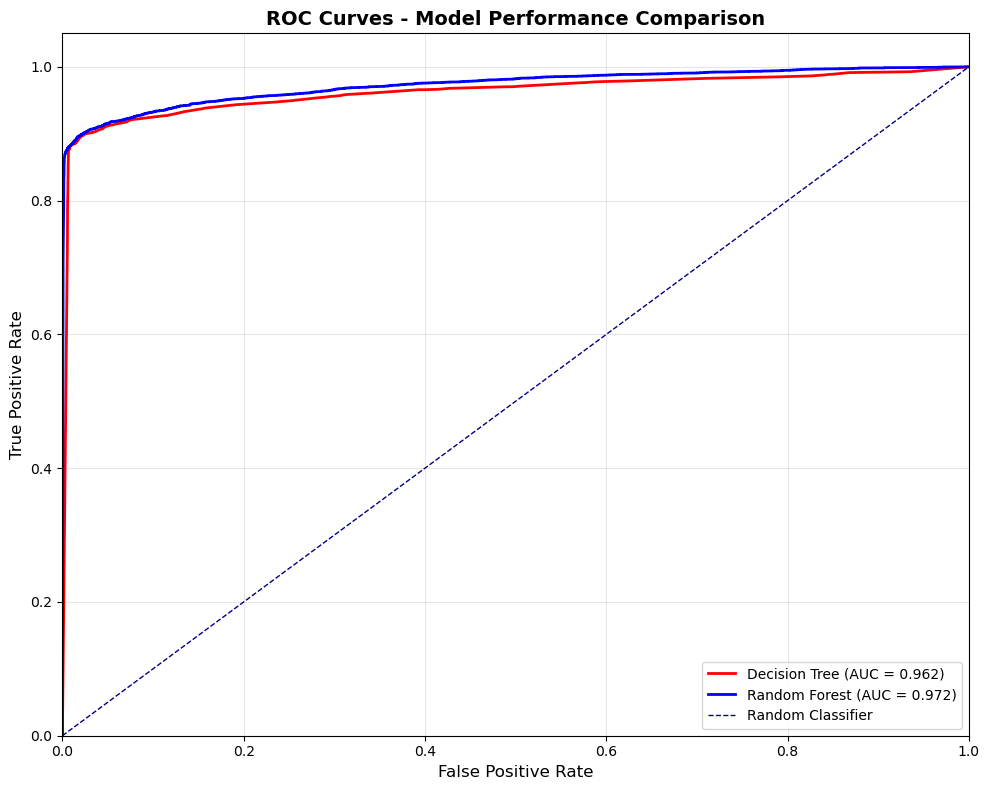

In [70]:
def compare_model_roc_performance(models_list, X_test, y_test, figsize=(10, 8)):
    """
    Compare ROC performance of multiple trained models
    
    Parameters:
    -----------
    models_list : list
        List of tuples (model_name, trained_model)
    X_test, y_test : array-like
        Test data
    figsize : tuple, optional
        Figure size
        
    Returns:
    --------
    roc_results : dict
        ROC metrics for each model
    """
    plt.figure(figsize=figsize)
    
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
    roc_results = {}
    
    print(" ROC Curve Analysis:")
    print("=" * 35)
    
    for i, (model_name, model) in enumerate(models_list):
        try:
            # Make predictions
            if hasattr(model, 'predict_proba'):
                # Use probability predictions for better ROC curve
                y_pred_proba = model.predict_proba(X_test)[:, 1]
                fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
            else:
                # Use binary predictions
                y_pred = model.predict(X_test)
                fpr, tpr, thresholds = roc_curve(y_test, y_pred)
            
            # Calculate AUC
            roc_auc = roc_auc_score(y_test, y_pred_proba if hasattr(model, 'predict_proba') else y_pred)
            
            # Plot curve
            color = colors[i % len(colors)]
            plt.plot(fpr, tpr, color=color, linewidth=2,
                    label=f'{model_name} (AUC = {roc_auc:.3f})')
            
            # Store results
            roc_results[model_name] = {
                'fpr': fpr,
                'tpr': tpr,
                'auc': roc_auc,
                'thresholds': thresholds
            }
            
            print(f"{model_name:18} AUC: {roc_auc:.4f}")
            
        except Exception as e:
            print(f"Error with {model_name}: {str(e)}")
    
    # Plot diagonal reference line
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', linewidth=1,
             label='Random Classifier')
    
    # Customize plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves - Model Performance Comparison', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return roc_results

# Example usage with available models
available_models = [
    ('Decision Tree', dt_model),
    ('Random Forest', rf_model),
]

# Generate ROC comparison
roc_analysis = compare_model_roc_performance(available_models, X_test, y_test)